# **MILESTONE 1 i 2**


## **Cel biznesowy:** Segmentacja klientów banku na podstawie ich zachowań transakcyjnych i typów kont w celu personalizacji ofert marketingowych i zwiększenia retencji klientów

**Korzyści wynikające dla banku z racji takiego pogrupowania klientów:**

- Możliwość kierowania odpowiednich ofert do odpowiednich klientów (np. lokaty dla klientów z dużym saldem).

- Identyfikacja klientów wysokiego ryzyka lub niskiej aktywności.

- Możliwość tworzenia kampanii retencyjnych dla segmentów o niskim zaangażowaniu.

### Wczytanie ramki danych

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/banking_dataset.csv")

## **Eksploracja i wstępna analiza danych**

In [1312]:
df.head()

,,Account ID;Customer Name;Account Type;Branch;Transaction Type;Transaction Amount;Account Balance;Currency
ACC00001;Amanda Pugh;Recurring Deposit;New York;Debit;2687,19;36676,19;GBP
ACC00002;Amanda Wilcox;Recurring Deposit;Houston;Debit;3886,77;28582,82;USD
ACC00003;Kimberly Valenzuela;Current;New York;Credit;2438,74;76599,56;GBP
ACC00004;Sonia Ballard;Recurring Deposit;Philadelphia;Credit;2758,53;62317,6;INR
ACC00005;Erika Russell;Current;Philadelphia;Debit;3287;85515,21;INR,NaN


Widzimy, że ramka danych po zapisaniu w pliku csv, nie ładuje się dobrze. Na szczęście jest na to rozwiązanie:

In [2]:
df = pd.read_csv("data/banking_dataset.csv", sep=";")


In [3]:
df.head()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
0,ACC00001,Amanda Pugh,Recurring Deposit,New York,Debit,"2687,19","36676,19",GBP
1,ACC00002,Amanda Wilcox,Recurring Deposit,Houston,Debit,"3886,77","28582,82",USD
2,ACC00003,Kimberly Valenzuela,Current,New York,Credit,"2438,74","76599,56",GBP
3,ACC00004,Sonia Ballard,Recurring Deposit,Philadelphia,Credit,"2758,53","62317,6",INR
4,ACC00005,Erika Russell,Current,Philadelphia,Debit,3287,"85515,21",INR


In [4]:
df.tail()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
9995,ACC09996,Richard Davis,Fixed Deposit,New York,Debit,"400,96","38035,17",USD
9996,ACC09997,Lauren Weber,Savings,Chicago,Debit,"3736,7","60682,41",EUR
9997,ACC09998,Nichole Stout,Fixed Deposit,Houston,Credit,"4002,91","36136,11",USD
9998,ACC09999,Kristen Wilkinson,Fixed Deposit,Philadelphia,Debit,"866,9","35644,82",GBP
9999,ACC10000,Brian Sandoval,Fixed Deposit,Philadelphia,Debit,"3932,81","32357,51",GBP


In [5]:
df.shape

(10000, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Account ID          10000 non-null  object
 1   Customer Name       10000 non-null  object
 2   Account Type        10000 non-null  object
 3   Branch              10000 non-null  object
 4   Transaction Type    10000 non-null  object
 5   Transaction Amount  10000 non-null  object
 6   Account Balance     10000 non-null  object
 7   Currency            10000 non-null  object
dtypes: object(8)
memory usage: 625.1+ KB


wszysktie kolumny są typu object - trzeba będzie to zmienić 

In [7]:
print(df.isnull().sum())

Account ID            0
Customer Name         0
Account Type          0
Branch                0
Transaction Type      0
Transaction Amount    0
Account Balance       0
Currency              0
dtype: int64


Brak pustych wartości

In [8]:
df.describe()

,Account ID,Customer Name,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
count,10000,10000,10000,10000,10000,10000,10000,10000
unique,10000,9323,4,8,2,9896,9995,5
top,ACC09984,William Williams,Savings,Philadelphia,Credit,"3398,97","21317,69",JPY
freq,1,7,2580,1288,5114,3,2,2041


## Po wstępnej analizie kolumn, usunięte zostaną kolumny 'Account ID' oraz 'Customer Name', są to informacje, które nie wnoszą żadnej informacji

komentarz: czy na pewno accountID? Czy nie warto zostawić dla samego celu identyfikacyjnego konta?

In [9]:
df = df.drop(['Account ID', 'Customer Name'], axis = 1)

In [10]:
df.head()

,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency
0,Recurring Deposit,New York,Debit,"2687,19","36676,19",GBP
1,Recurring Deposit,Houston,Debit,"3886,77","28582,82",USD
2,Current,New York,Credit,"2438,74","76599,56",GBP
3,Recurring Deposit,Philadelphia,Credit,"2758,53","62317,6",INR
4,Current,Philadelphia,Debit,3287,"85515,21",INR


In [11]:
df.drop_duplicates(inplace=True) #to może nie być poprawne

Możemy teraz przejść do dalszej eksploracji danych, najpierw zmieńmy typy danych w kolumnach, aby móc operować na zmiennych liczbowych

In [12]:
#df['Transaction Amount'] = pd.to_numeric(df['Transaction Amount'], errors='coerce')
#df['Account Balance'] = pd.to_numeric(df['Account Balance'], errors='coerce')

df['Transaction Amount'] = df['Transaction Amount'].str.replace(',', '.').astype(float)
df['Account Balance'] = df['Account Balance'].str.replace(',', '.').astype(float)

^ tutaj był błąd, zakomentowany kod psuł tabelę

Sprawdźmy unikalne wartości i ich ilość dla poszczególnych kolumn

In [13]:
print(df.dtypes)

Account Type           object
Branch                 object
Transaction Type       object
Transaction Amount    float64
Account Balance       float64
Currency               object
dtype: object


In [14]:
for col in ['Account Type', 'Branch', 'Transaction Type', 'Currency']:
    print(f"\nUnikalne wartości w kolumnie {col}:")
    print(df[col].value_counts())


Unikalne wartości w kolumnie Account Type:
Account Type
Savings              2580
Current              2529
Fixed Deposit        2489
Recurring Deposit    2402
Name: count, dtype: int64

Unikalne wartości w kolumnie Branch:
Branch
Philadelphia    1288
Phoenix         1274
Los Angeles     1268
Houston         1259
New York        1256
Chicago         1239
San Antonio     1233
San Diego       1183
Name: count, dtype: int64

Unikalne wartości w kolumnie Transaction Type:
Transaction Type
Credit    5114
Debit     4886
Name: count, dtype: int64

Unikalne wartości w kolumnie Currency:
Currency
JPY    2041
EUR    2039
USD    2035
GBP    1958
INR    1927
Name: count, dtype: int64


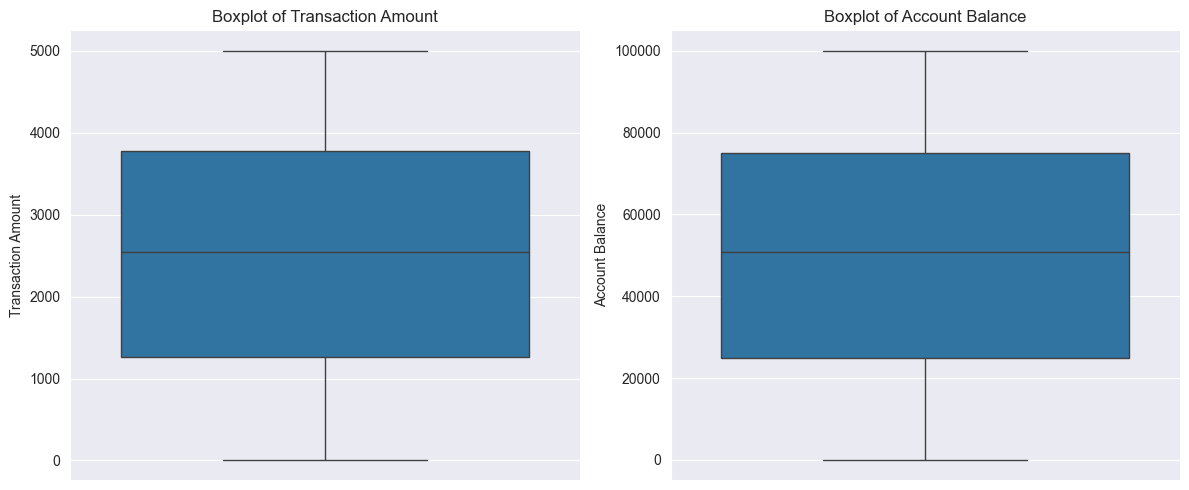

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Transaction Amount'])
plt.title('Boxplot of Transaction Amount')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Account Balance'])
plt.title('Boxplot of Account Balance')
plt.tight_layout()
plt.show()

**Nie ma widocznych żadnych outlierów.**

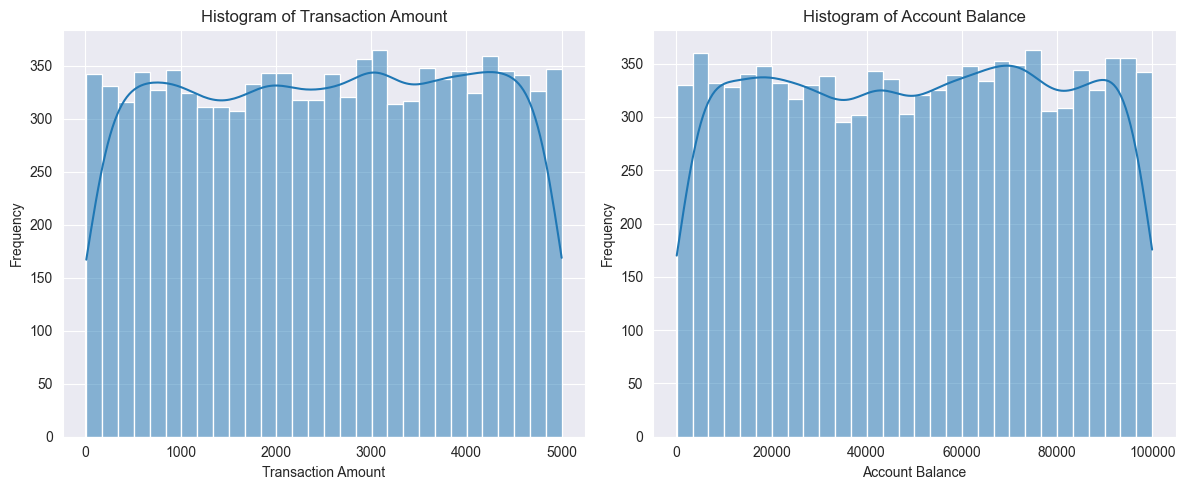

In [16]:
plt.figure(figsize=(12, 5))

# Transaction amount
plt.subplot(1, 2, 1)
sns.histplot(df['Transaction Amount'], bins=30, kde=True)
plt.title('Histogram of Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Acc balance
plt.subplot(1, 2, 2)
sns.histplot(df['Account Balance'], bins=30, kde=True)
plt.title('Histogram of Account Balance')
plt.xlabel('Account Balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

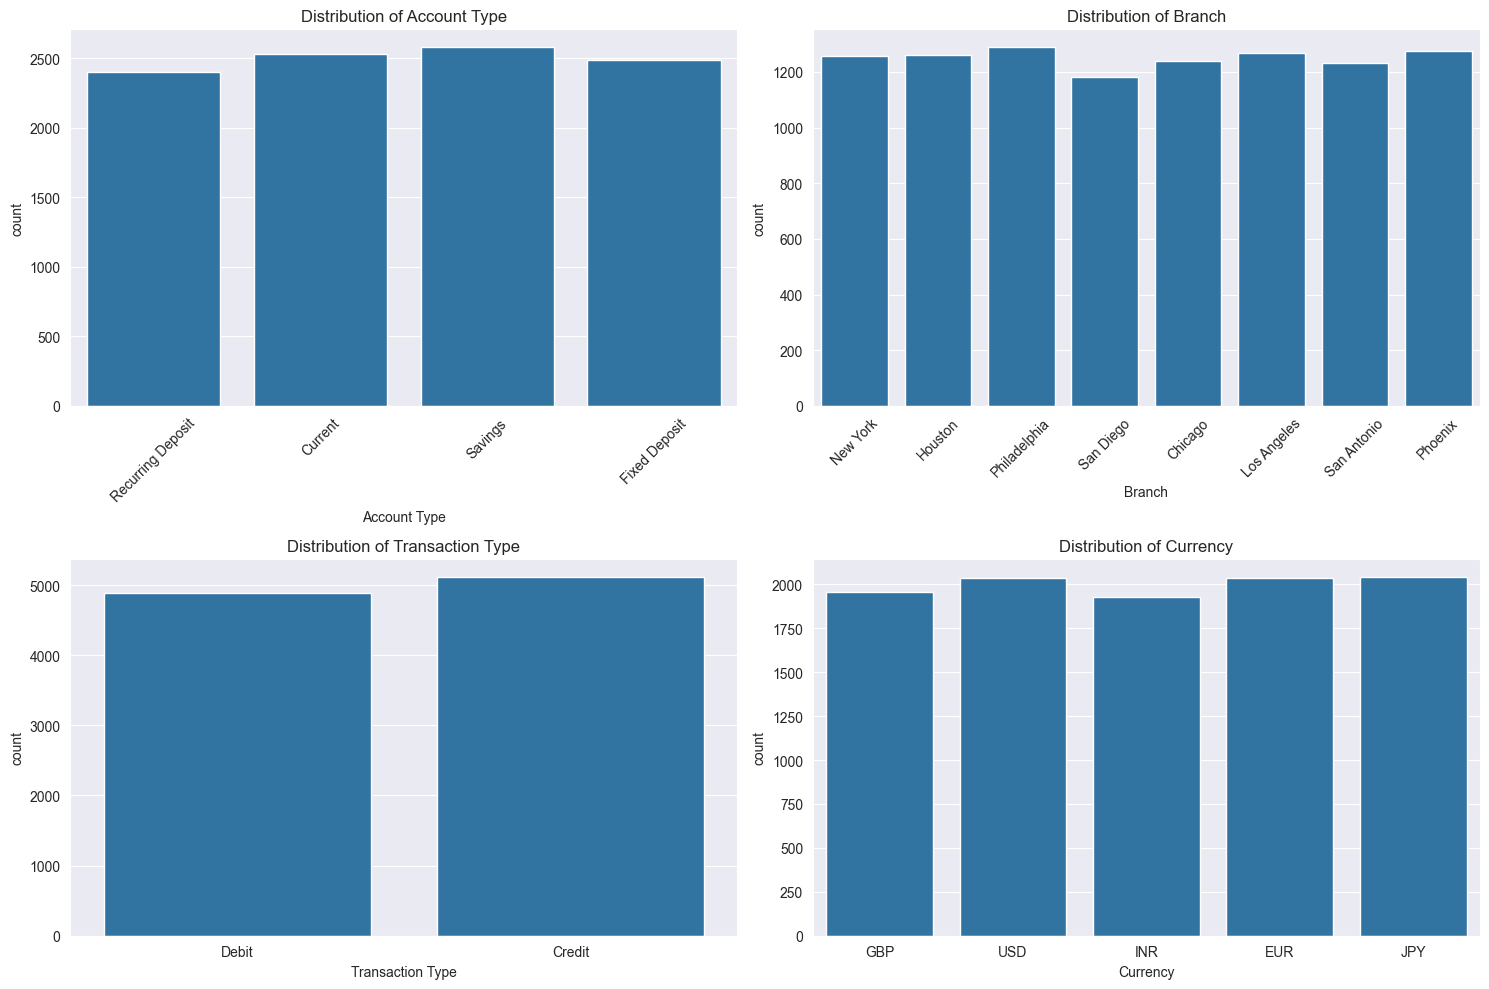

In [17]:
# Count plots for categorical variables
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.countplot(x='Account Type', data=df)
plt.title('Distribution of Account Type')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.countplot(x='Branch', data=df)
plt.title('Distribution of Branch')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.countplot(x='Transaction Type', data=df)
plt.title('Distribution of Transaction Type')

plt.subplot(2, 2, 4)
sns.countplot(x='Currency', data=df)
plt.title('Distribution of Currency')
plt.tight_layout()
plt.show()


Dla każdej zmiennej kategorycznej zliczenia możliwych wartości są rozłożone mniej więcej po równo.

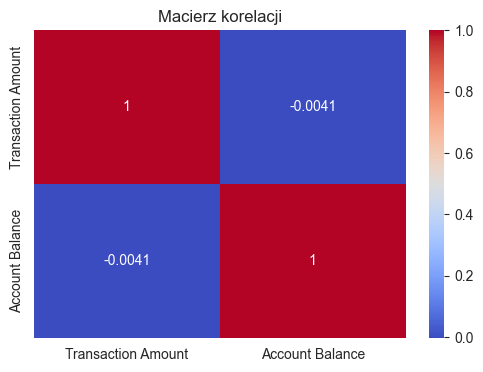

In [18]:
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()

Pomiędzy zmiennymi numerycznymi nie zachodzi korelacja

In [19]:
print(df.groupby('Account Type')['Transaction Amount'].mean())

print(df.groupby('Currency')['Account Balance'].mean())


Account Type
Current              2502.820059
Fixed Deposit        2546.617151
Recurring Deposit    2512.312627
Savings              2536.010089
Name: Transaction Amount, dtype: float64
Currency
EUR    50502.715473
GBP    49906.100516
INR    51049.621271
JPY    49827.480314
USD    50091.525027
Name: Account Balance, dtype: float64


Nie widać na piewrszy rzut oka żadnej zależności pomiędzy średnią wartością transakcji/stanem konta a walutą w jakiej prowadzone jest konto

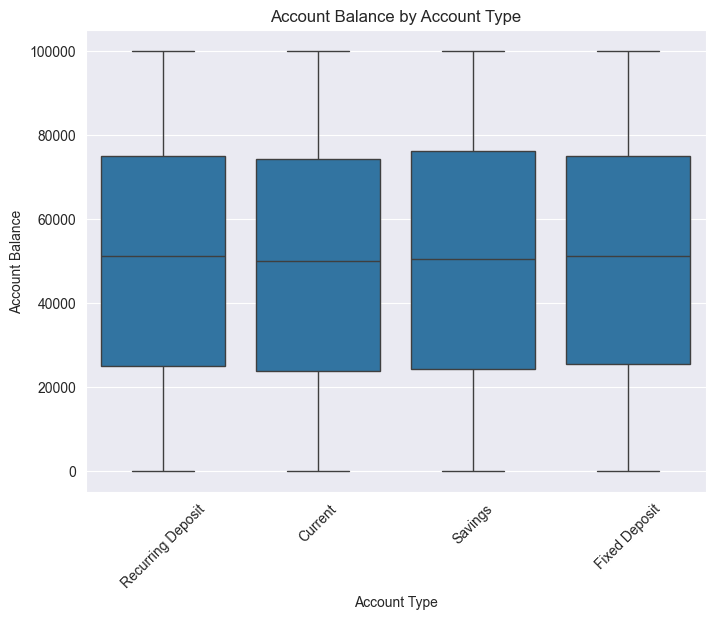

In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Account Type', y='Account Balance', data=df)
plt.title('Account Balance by Account Type')
plt.xticks(rotation=45)
plt.show()

Brak outlierów. Rozkład stanu konta w zależności od typu konta

In [21]:
# Cross-tabulation of Account Type and Transaction Type
print(pd.crosstab(df['Account Type'], df['Transaction Type']))

Transaction Type   Credit  Debit
Account Type                    
Current              1323   1206
Fixed Deposit        1266   1223
Recurring Deposit    1206   1196
Savings              1319   1261


Po równo.

# **Inżynieria cech**

## **Zamiana na jedną walutę i ponowne przeprowadzenie analizy**

In [27]:
exchange_rates = {'USD': 1.0, 'EUR': 1.08, 'GBP': 1.27, 'INR': 0.012, 'JPY': 0.0066}

# Zamiana na USD
df['Transaction Amount USD'] = df.apply(lambda x: float(x['Transaction Amount']) * exchange_rates.get(x['Currency'], 1.0), axis=1)
df['Account Balance USD'] = df.apply(lambda x: float(x['Account Balance']) * exchange_rates.get(x['Currency'], 1.0), axis=1)

# sprawdzamy czy dizała
print(df[['Transaction Amount USD', 'Account Balance USD']].describe())


       Transaction Amount USD  Account Balance USD
count            10000.000000         10000.000000
mean              1704.556596         33910.047464
std               1870.159242         37213.913721
min                  0.082434             0.897336
25%                 26.736683           535.726967
50%                950.329000         18802.265000
75%               3277.854375         65177.548200
max               6347.510800        126968.999300


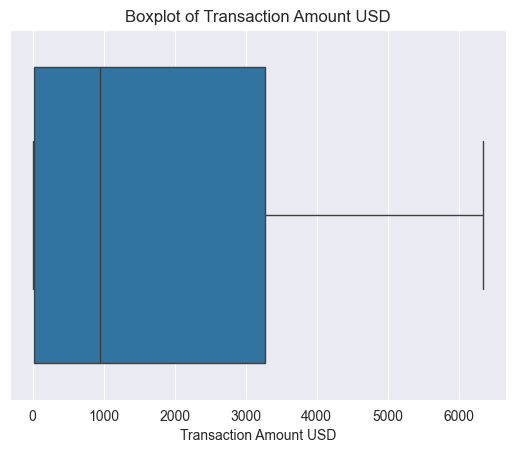

In [23]:
sns.boxplot(x=df['Transaction Amount USD'])
plt.title('Boxplot of Transaction Amount USD')
plt.show()

brak outlierów

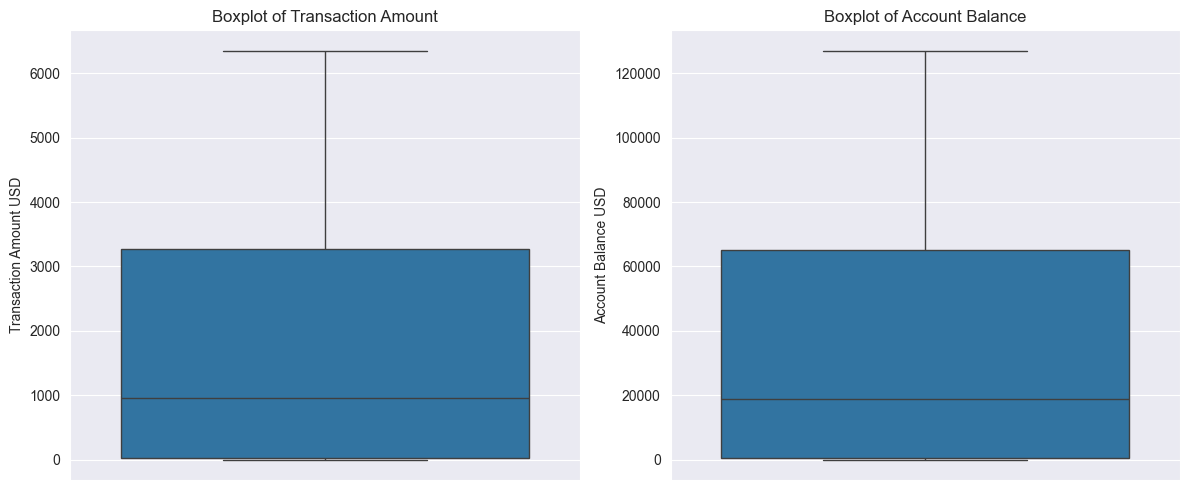

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Transaction Amount USD'])
plt.title('Boxplot of Transaction Amount')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Account Balance USD'])
plt.title('Boxplot of Account Balance')
plt.tight_layout()
plt.show()

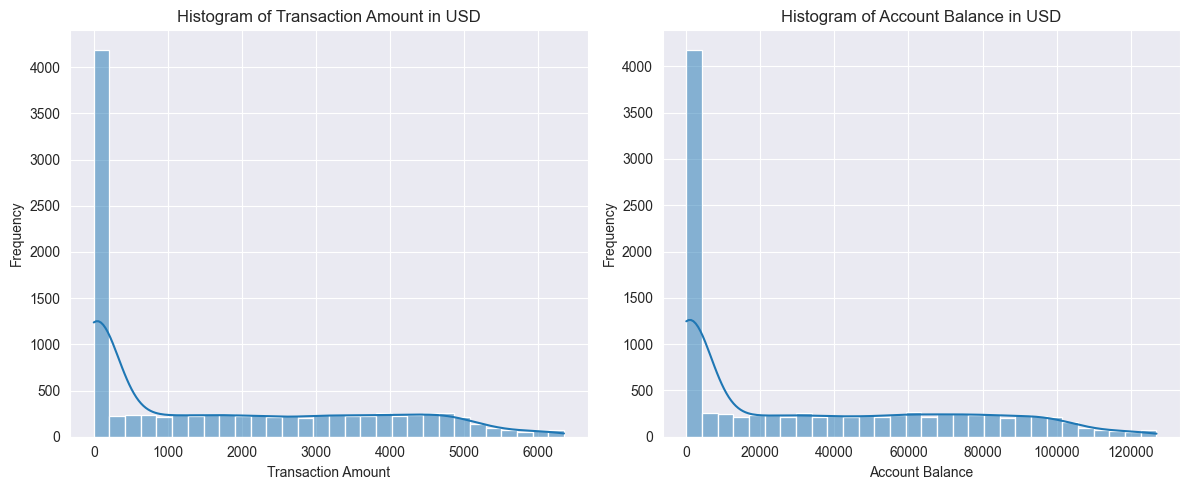

In [25]:
plt.figure(figsize=(12, 5))

# Histogram dla Transaction Amount
plt.subplot(1, 2, 1)
sns.histplot(df['Transaction Amount USD'], bins=30, kde=True)
plt.title('Histogram of Transaction Amount in USD')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Histogram dla Account Balance
plt.subplot(1, 2, 2)
sns.histplot(df['Account Balance USD'], bins=30, kde=True)
plt.title('Histogram of Account Balance in USD')
plt.xlabel('Account Balance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Bardzo mocna skośność, można rozważyć logarytmowanie - lub wykluczenie zmiennej (nwm)

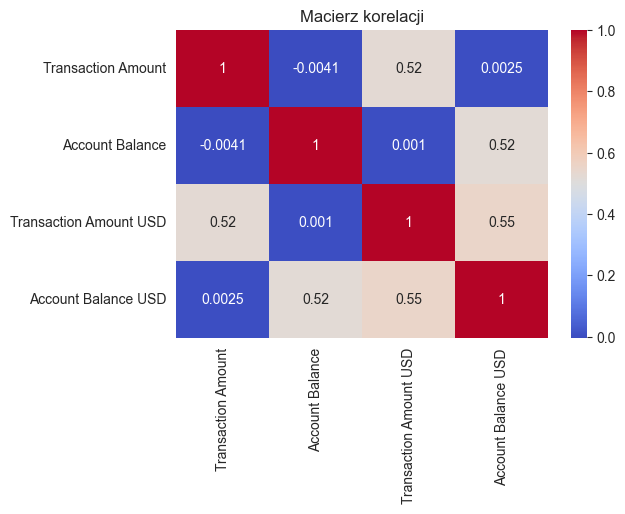

In [26]:
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()

**Przeskalowanie wartości** dla wartości numerycznych sprowadzając wszystko do jednej waluty daje ciekawe informacje. Jednak mimo wszystko wydaje się, że może być to mało wartościowa zmienna.

komentarz: dla mnie spoko

## Nowa zmienna

In [28]:
df['Balance_to_Transaction_Ratio'] = df['Account Balance'] / df['Transaction Amount']

może być wrażliwe na outliery

Text(0, 0.5, 'Frequency')

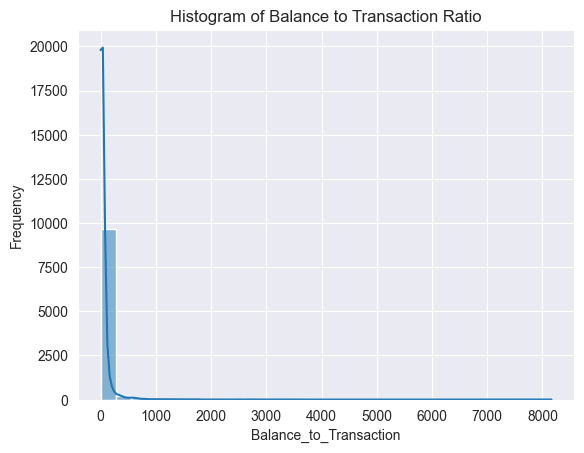

In [29]:
sns.histplot(df['Balance_to_Transaction_Ratio'], bins=30, kde=True)
plt.title('Histogram of Balance to Transaction Ratio')
plt.xlabel('Balance_to_Transaction')
plt.ylabel('Frequency')

In [30]:
df['Log_Balance_to_Transaction_Ratio'] = np.log1p(df['Balance_to_Transaction_Ratio'].clip(lower=1e-6))

Text(0, 0.5, 'Frequency')

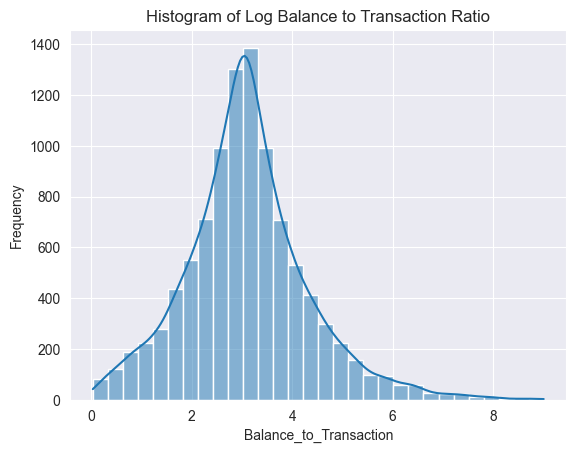

In [31]:
sns.histplot(df['Log_Balance_to_Transaction_Ratio'], bins=30, kde=True)
plt.title('Histogram of Log Balance to Transaction Ratio')
plt.xlabel('Balance_to_Transaction')
plt.ylabel('Frequency')

In [44]:
print(df[df['Account Balance USD'] < 0].shape)  
print(df[df['Transaction Amount USD'] <= 0].shape)  

(0, 13)
(0, 13)


brak ujemnych sald

## To samo tylko w drugą stronę

In [27]:
df['Transaction_To_Balance_Ratio'] = df['Transaction Amount'] / df['Account Balance']

Text(0, 0.5, 'Frequency')

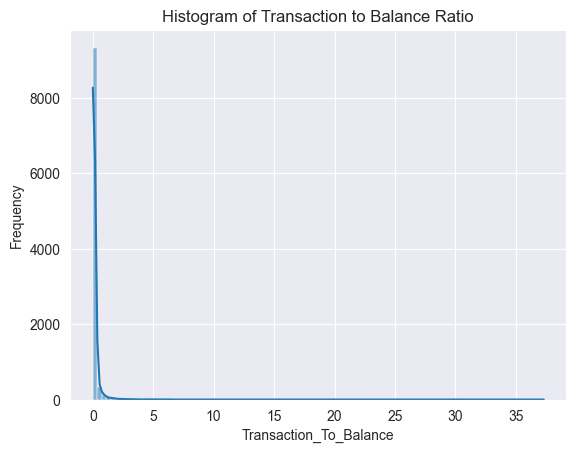

In [29]:
sns.histplot(df['Transaction_To_Balance_Ratio'], bins=100, kde=True)
plt.title('Histogram of Transaction to Balance Ratio')
plt.xlabel('Transaction_To_Balance')
plt.ylabel('Frequency')

In [30]:
df['Log_Transaction_To_Balance_Ratio'] = np.log1p(df['Transaction_To_Balance_Ratio'].clip(lower=1e-6))

Text(0, 0.5, 'Frequency')

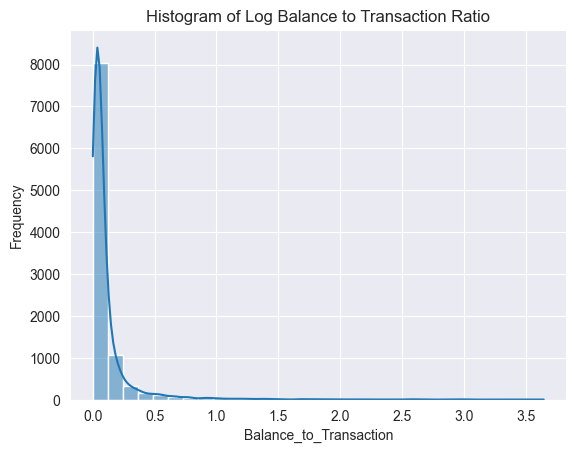

In [31]:
sns.histplot(df['Log_Transaction_To_Balance_Ratio'], bins=30, kde=True)
plt.title('Histogram of Log Balance to Transaction Ratio')
plt.xlabel('Balance_to_Transaction')
plt.ylabel('Frequency')

Wygląda gorzej, ale muszę zostać przekonany. Zupełnie się nie spodziewałem, że tak gorzej to będzie wyglądało

Zmiana zmiennych kategorycznych

In [32]:
df['Transaction Type'] = df['Transaction Type'].map({'Debit': 0, 'Credit': 1})

In [33]:
df['Activity_Ratio'] = df['Transaction Amount USD'] / (df['Account Balance USD'] + 1)

Zmienne odpowiadające za to czy ktoś robi więcej dużych czy mniej transakcji (też poproszę o opinię)

In [1345]:
df['Account_Type_Original'] = df['Account Type'].copy()
df = pd.get_dummies(df, columns=['Account Type'], prefix='Account_Type')
df['Transaction_Amount_Relative_to_Mean'] = df['Transaction Amount USD'] / df.groupby('Account_Type_Original')['Transaction Amount USD'].transform('mean')
df = df.drop('Account_Type_Original', axis=1)

In [1346]:
df = pd.get_dummies(df, columns=['Currency'], prefix='Currency')

In [1347]:
df['Log_Activity_Ratio'] = np.log1p(df['Activity_Ratio'].clip(lower=1e-6))

In [1348]:
df.describe()

,Transaction Type,Transaction Amount,Account Balance,Transaction Amount USD,Account Balance USD,Balance_to_Transaction_Ratio,Log_Balance_to_Transaction_Ratio,Activity_Ratio,Transaction_Amount_Relative_to_Mean,Log_Activity_Ratio
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.511400,2524.564298,50269.794260,1704.556596,33910.047464,61.379967,3.093531,0.165080,1.000000,0.108222
std,0.499895,1444.318039,29057.726646,1870.159242,37213.913721,252.298729,1.220871,0.812966,1.097227,0.219163
min,0.000000,10.970000,101.890000,0.082434,0.897336,0.026799,0.026447,0.000122,0.000049,0.000122
25%,0.000000,1263.912500,24863.487500,26.736683,535.726967,9.917744,2.390389,0.025280,0.015712,0.024966
50%,1.000000,2544.655000,50790.475000,950.329000,18802.265000,19.914487,3.040442,0.050167,0.556743,0.048949
75%,1.000000,3781.757500,75128.187500,3277.854375,65177.548200,39.532359,3.702101,0.100687,1.922764,0.095935
max,1.000000,4999.790000,99975.590000,6347.510800,126968.999300,8163.276436,9.007523,36.978318,3.758784,3.637015


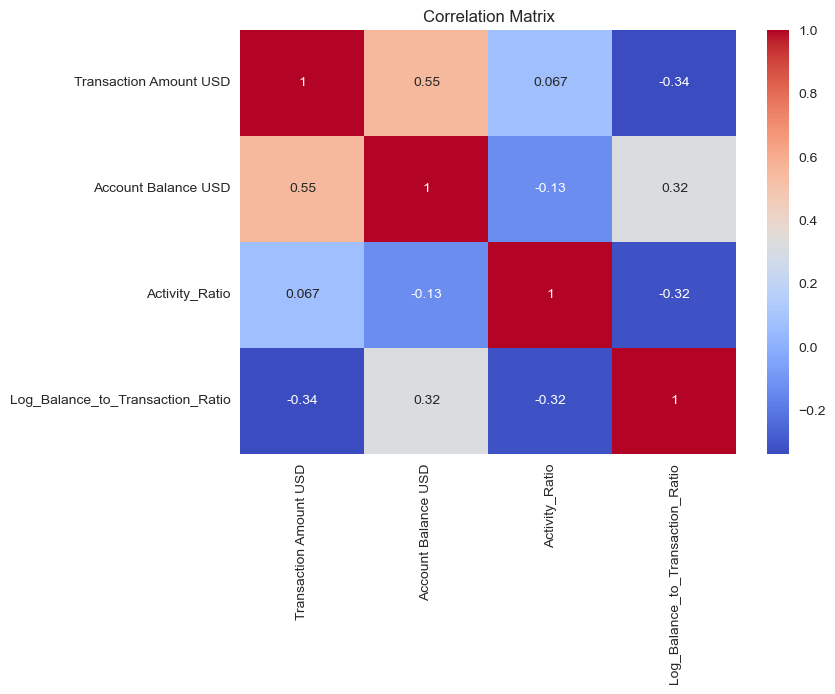

In [1349]:
correlation_matrix = df[['Transaction Amount USD', 'Account Balance USD', 'Activity_Ratio', 'Log_Balance_to_Transaction_Ratio']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [1350]:
df.describe()

,Transaction Type,Transaction Amount,Account Balance,Transaction Amount USD,Account Balance USD,Balance_to_Transaction_Ratio,Log_Balance_to_Transaction_Ratio,Activity_Ratio,Transaction_Amount_Relative_to_Mean,Log_Activity_Ratio
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.511400,2524.564298,50269.794260,1704.556596,33910.047464,61.379967,3.093531,0.165080,1.000000,0.108222
std,0.499895,1444.318039,29057.726646,1870.159242,37213.913721,252.298729,1.220871,0.812966,1.097227,0.219163
min,0.000000,10.970000,101.890000,0.082434,0.897336,0.026799,0.026447,0.000122,0.000049,0.000122
25%,0.000000,1263.912500,24863.487500,26.736683,535.726967,9.917744,2.390389,0.025280,0.015712,0.024966
50%,1.000000,2544.655000,50790.475000,950.329000,18802.265000,19.914487,3.040442,0.050167,0.556743,0.048949
75%,1.000000,3781.757500,75128.187500,3277.854375,65177.548200,39.532359,3.702101,0.100687,1.922764,0.095935
max,1.000000,4999.790000,99975.590000,6347.510800,126968.999300,8163.276436,9.007523,36.978318,3.758784,3.637015


Czy wywalamy kolumnę Branch?

## NOTATNIK WRZUCONY DO CHATA I ZEBY ZROBIL COKOLWIEK WIEC NWM CO TO ALE COS ROBI WIEC ZOSTAWIAM XD

In [1351]:
from sklearn.preprocessing import StandardScaler
numeric_cols = ['Transaction Amount USD', 'Account Balance USD', 'Activity_Ratio', 'Log_Balance_to_Transaction_Ratio', 'Transaction_Amount_Relative_to_Mean']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

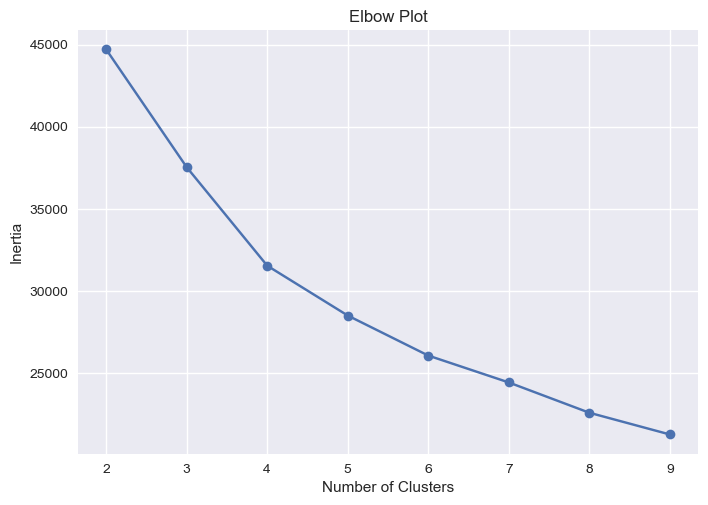

c:\Users\48530\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [1352]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Wybór cech do klasteryzacji
features = ['Transaction Amount USD', 'Account Balance USD', 'Activity_Ratio', 'Log_Balance_to_Transaction_Ratio', 'Transaction_Amount_Relative_to_Mean'] + \
           [col for col in df.columns if col.startswith('Account_Type_') or col.startswith('Currency_')]

# Określenie optymalnej liczby klastrów
inertias = []
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[features])
    inertias.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(df[features], kmeans.labels_))

# Wykres elbow
plt.plot(range(2, 10), inertias, marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Klasteryzacja z wybraną liczbą klastrów
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[features])

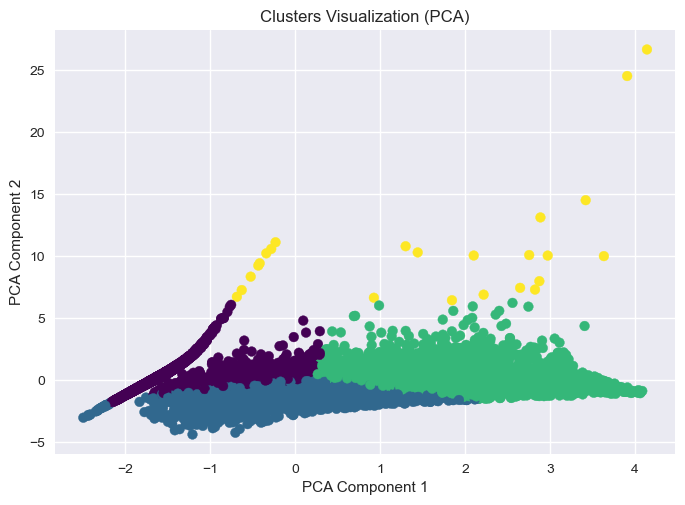

In [1353]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[features])
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('Clusters Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

+ NIE WYGLĄDA ŹLE (chyba, bo nwm co sie dzieje w tym kodzie)

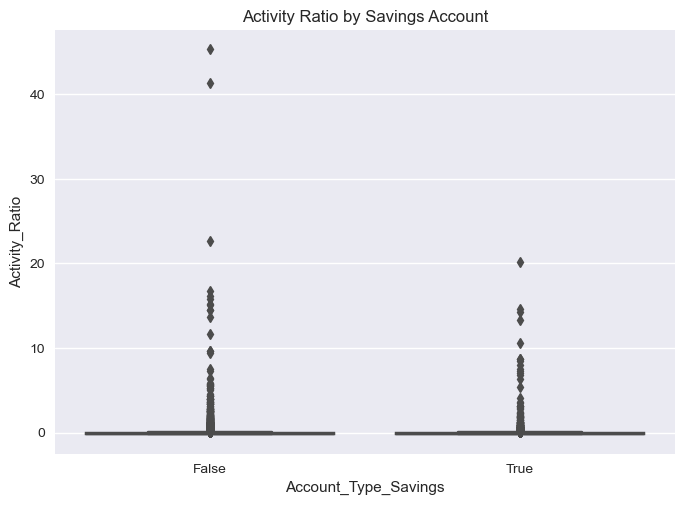

In [1354]:
sns.boxplot(x='Account_Type_Savings', y='Activity_Ratio', data=df)
plt.title('Activity Ratio by Savings Account')
plt.show()

In [1355]:
silhouette_avg = silhouette_score(df[features], df['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.2938502721891494


## Od początku

### EDA

In [16]:
df = pd.read_csv("data/banking_dataset.csv", sep=";")

In [38]:
df.head()

,Account Type,Branch,Transaction Type,Transaction Amount,Account Balance,Currency,Transaction Amount USD,Account Balance USD,Balance_to_Transaction_Ratio,Log_Balance_to_Transaction_Ratio
0,Recurring Deposit,New York,Debit,2687.19,36676.19,GBP,3412.73130,46578.76130,13.648529,2.684340
1,Recurring Deposit,Houston,Debit,3886.77,28582.82,USD,3886.77000,28582.82000,7.353875,2.122725
2,Current,New York,Credit,2438.74,76599.56,GBP,3097.19980,97281.44120,31.409482,3.478451
3,Recurring Deposit,Philadelphia,Credit,2758.53,62317.60,INR,33.10236,747.81120,22.590873,3.160860
4,Current,Philadelphia,Debit,3287.00,85515.21,INR,39.44400,1026.18252,26.016188,3.296436


In [17]:
df.info

<bound method DataFrame.info of      Account ID        Customer Name       Account Type        Branch  \
0      ACC00001          Amanda Pugh  Recurring Deposit      New York   
1      ACC00002        Amanda Wilcox  Recurring Deposit       Houston   
2      ACC00003  Kimberly Valenzuela            Current      New York   
3      ACC00004        Sonia Ballard  Recurring Deposit  Philadelphia   
4      ACC00005        Erika Russell            Current  Philadelphia   
...         ...                  ...                ...           ...   
9995   ACC09996        Richard Davis      Fixed Deposit      New York   
9996   ACC09997         Lauren Weber            Savings       Chicago   
9997   ACC09998        Nichole Stout      Fixed Deposit       Houston   
9998   ACC09999    Kristen Wilkinson      Fixed Deposit  Philadelphia   
9999   ACC10000       Brian Sandoval      Fixed Deposit  Philadelphia   

     Transaction Type Transaction Amount Account Balance Currency  
0               Debit  

In [18]:
df = df.drop(['Account ID', 'Customer Name'], axis = 1)

In [19]:
df.shape

(10000, 6)

In [20]:
df.drop_duplicates(inplace=True) #to może nie być poprawne

In [21]:
df.shape

(10000, 6)

In [22]:
df['Transaction Amount'] = df['Transaction Amount'].str.replace(',', '.').astype(float)
df['Account Balance'] = df['Account Balance'].str.replace(',', '.').astype(float)

In [23]:
print(df.dtypes)

Account Type           object
Branch                 object
Transaction Type       object
Transaction Amount    float64
Account Balance       float64
Currency               object
dtype: object


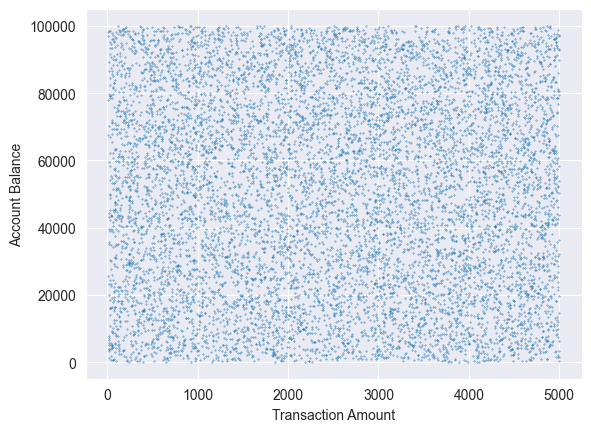

In [26]:
plt.scatter(df['Transaction Amount'], df['Account Balance'], s=0.1)
plt.xlabel('Transaction Amount')
plt.ylabel('Account Balance')
plt.show()

In [32]:
df.columns

Index(['Account Type', 'Branch', 'Transaction Type', 'Transaction Amount',
       'Account Balance', 'Currency', 'Transaction Amount USD',
       'Account Balance USD', 'Balance_to_Transaction_Ratio',
       'Log_Balance_to_Transaction_Ratio'],
      dtype='object')

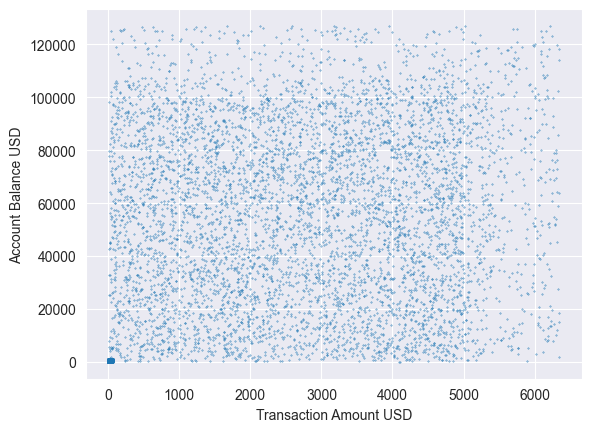

In [33]:
plt.scatter(df['Transaction Amount USD'], df['Account Balance USD'], s=0.1)
plt.xlabel('Transaction Amount USD')
plt.ylabel('Account Balance USD')
plt.show()

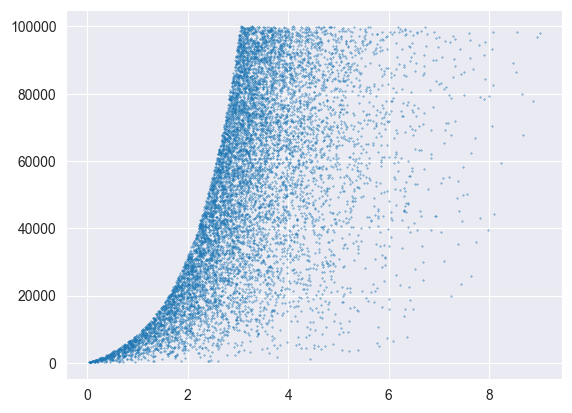

In [37]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Account Balance'], s=0.1)
plt.show()

### Preprocessing

In [39]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['Account Type'] = le.fit_transform(df['Account Type'])
df['Transaction Type'] = le.fit_transform(df['Transaction Type'])
df['Branch'] = le.fit_transform(df['Branch'])

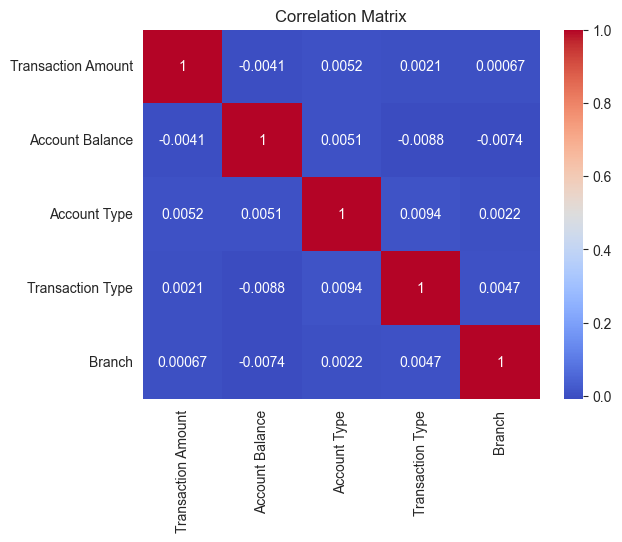

In [41]:
cm = df[['Transaction Amount', 'Account Balance', 'Account Type', 'Transaction Type', 'Branch']].corr()
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

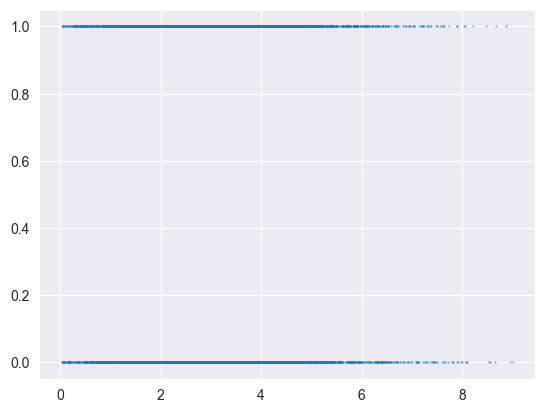

In [45]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Transaction Type'], s=0.1)
plt.show()

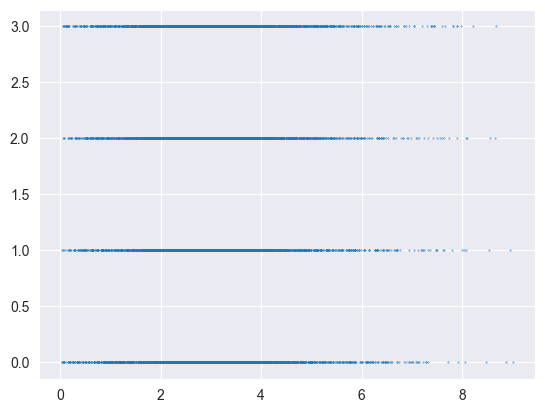

In [47]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Account Type'], s=0.1)
plt.show()

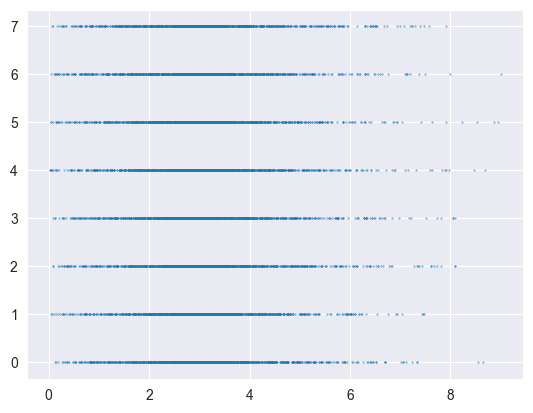

In [48]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Branch'], s=0.1)
plt.show()

Jak dla mnie to tutaj jest turbo słabo. Tu nie ma żadnych zależności i tak jak mówiłaś to raczej są dane sztucznie wygenerowane. Wszystko jest od siebie niezależne więc nie rozumiem co my mamy zrobić.

### Jakieś żałosne próby klasteryzacji

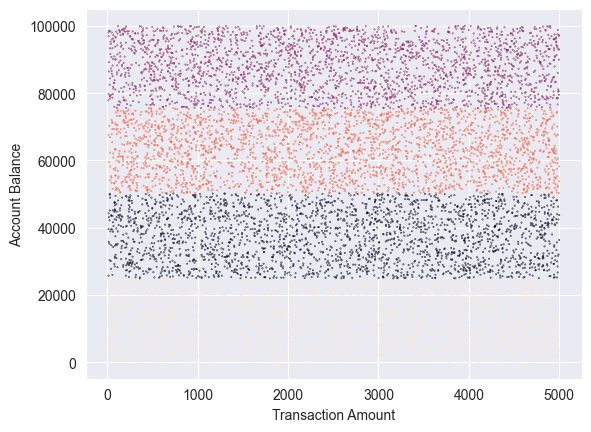

In [50]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)

df['Cluster'] = kmeans.fit_predict(df[['Transaction Amount', 'Account Balance', 'Account Type', 'Transaction Type', 'Branch', 'Log_Balance_to_Transaction_Ratio']])

plt.scatter(df['Transaction Amount'], df['Account Balance'], s=0.1, c=df['Cluster'])
plt.xlabel('Transaction Amount')
plt.ylabel('Account Balance')
plt.show()

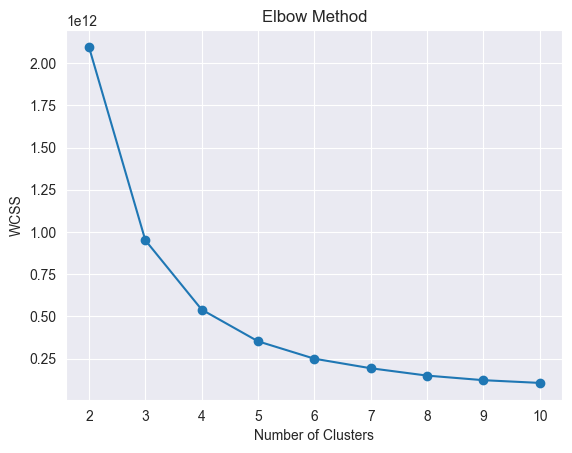

In [59]:
wcss = []
scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df[['Transaction Amount', 'Account Balance', 'Account Type', 'Transaction Type', 'Branch', 'Log_Balance_to_Transaction_Ratio']])
    wcss.append(kmeans.inertia_)
    scores.append(silhouette_score(df[['Transaction Amount', 'Account Balance', 'Account Type', 'Transaction Type', 'Branch', 'Log_Balance_to_Transaction_Ratio']], kmeans.labels_))

# Elbow plot
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

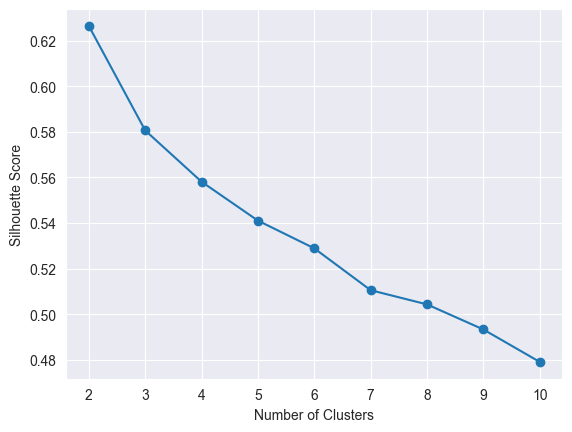

In [60]:
plt.plot(range(2, 11), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


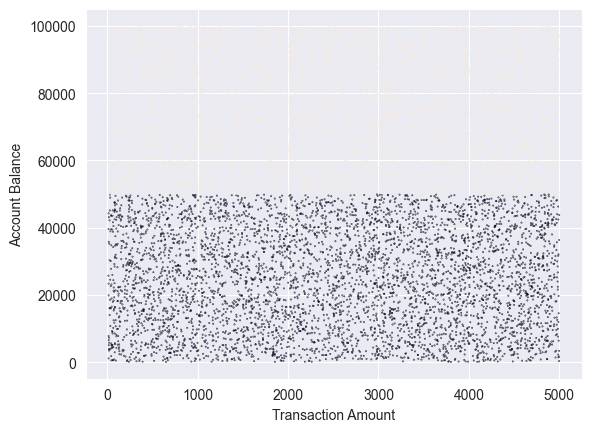

In [61]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)

df['Cluster'] = kmeans.fit_predict(df[['Transaction Amount', 'Account Balance', 'Account Type', 'Transaction Type', 'Branch', 'Log_Balance_to_Transaction_Ratio']])

plt.scatter(df['Transaction Amount'], df['Account Balance'], s=0.1, c=df['Cluster'])
plt.xlabel('Transaction Amount')
plt.ylabel('Account Balance')
plt.show()

XD

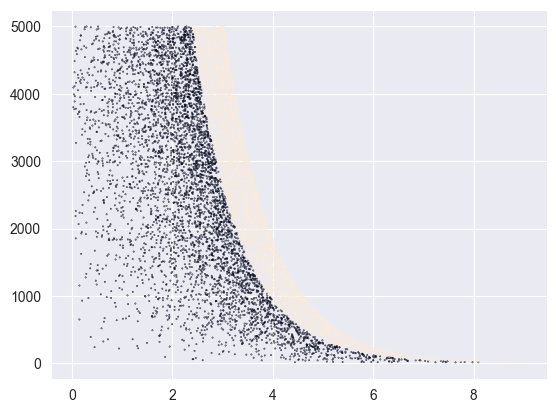

In [64]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Transaction Amount'], s=0.1, c=df['Cluster'])
plt.show()

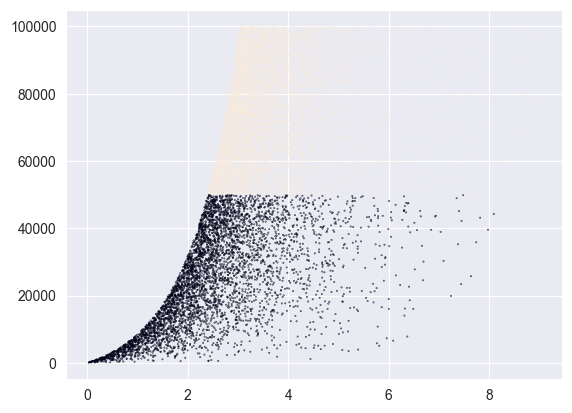

In [65]:
plt.scatter(df['Log_Balance_to_Transaction_Ratio'], df['Account Balance'], s=0.1, c=df['Cluster'])
plt.show()

Tutaj nic nie ma moim zdaniem. Zero elementów ciekawych. Nie da się tego "sklastrować"